In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
from nm_lib import nm_lib as nm
import importlib
from IPython.display import HTML
import scipy.optimize
importlib.reload(nm)

<module 'nm_lib.nm_lib' from '/home/astronih/Documents/nm_lib/nm_lib/nm_lib.py'>

Will solve the following equations in one dimension

$$ \frac{\partial \rho}{\partial t} + \nabla \cdot (\rho \bf u) = 0 $$

$$ \frac{\partial \rho {\bf u}}{\partial t} + \nabla \cdot (\rho {\bf u} \otimes {\bf u}) = - \nabla (P_g)$$

$$ \frac{\partial e}{\partial t } = -\nabla\cdot e {\bf u} -P_g \nabla \cdot {\bf u}$$

Following then the continuity equation in 1D

$$
\begin{align}
\frac{\partial \rho}{\partial t} &= -\frac{\partial \rho u}{\partial x} \\
\end{align}
$$

But in order to solve this we must first numerically solve $\frac{\partial \rho u}{\partial x}$

$$
\begin{align}
\frac{\partial \rho u}{\partial x} &= \left(u \frac{\partial \rho}{\partial x} + \rho \frac{\partial u}{\partial x}\right)
\end{align}
$$
And the LHS becomes
$$
\begin{align}
\frac{\partial \rho}{\partial t} = \frac{\rho^{n+1} - \rho^n}{\Delta t}
\end{align}
$$
Then 
$$
\rho^{n+1} = \rho^n - \Delta t \left(u^n \left[\frac{\partial \rho}{\partial x}\right]^n + \rho^n \left[\frac{\partial u}{\partial x}\right]^n\right)
$$
Where the brackets represent the derivative scheme, which is going to be dependent on the flow direction

Now for the momentum equation

$$
\begin{align}
\frac{\partial (\rho \mathbf{u})}{\partial t} + \nabla \cdot (\rho \mathbf{u} \otimes \mathbf{u}) = -\nabla (P_g)
\end{align}
$$
In one dimension we have then
$$
\begin{align}
\frac{\partial (\rho u)}{\partial t} + \frac{\partial \left(\rho u^2\right)}{\partial x} = -\frac{\partial}{\partial x} (P_g)
\end{align}
$$

We have already done the first term, so the second term with the help of product rule becomes
$$
\begin{align}
\frac{\partial \left(\rho u^2\right)}{\partial x} &= \rho u \frac{\partial u}{\partial x} + u\frac{\partial (\rho u)}{\partial x}
\end{align}
$$
This turns the momentum equation into
$$
\begin{align}
\frac{\partial (\rho u)}{\partial t} + \rho u \frac{\partial u}{\partial x} + u\frac{\partial (\rho u)}{\partial x}= -\frac{\partial}{\partial x} (P_g)
\end{align}
$$
Discretized
$$
\begin{align}
\left[\frac{\partial (\rho u)}{\partial t}\right]^n =- \left[\rho u\right]^n \left[\frac{\partial u}{\partial x}\right]^n - u^n\left[\frac{\partial (\rho u)}{\partial x}\right]^n-\left[\frac{\partial}{\partial x} (P_g)\right]^n
\end{align}
$$
But this is also aprroximated to
$$
\left[\frac{\partial \rho u}{\partial t}\right]^n \approx \frac{\left[\rho u\right]^{n+1} - \left[\rho u\right]^n}{\Delta t}
$$
Meaning we get
$$
u^{n+1} = \frac{\left[\rho u\right]^n + \left[\frac{\partial \rho u}{\partial t}\right]^n \Delta t}{\rho^{n+1}}\
$$
Where again we must be carefull of which scheme to use on $\frac{\partial \rho u}{\partial t}$

Lastly the energy equation

$$
\frac{\partial e}{\partial t} = - \frac{\partial (eu)}{\partial x} - P\frac{\partial u}{\partial x}
$$
RHS turns into
$$
-\frac{\partial (eu)}{\partial x} - P\frac{\partial u}{\partial x} = -(e + P) \frac{\partial u}{\partial x} - u\frac{\partial e}{\partial x}
$$
So energy
$$
e^{n+1} = e^n + \left[\frac{\partial e}{\partial t}\right]^n \Delta t
$$

Only LAX method in Julia, start with implenting just Python.

Hint from tor. Make Lax in SOD Laxer

1/3 * (np.roll(rho*uy, -1) +rho*uy + np.roll(rho*uy, +1)) + rhs * dt

In [33]:
def e_step(xx, uu, e, Pg, dt):
    """
    Returns the e^{n+1} in the energy equation

    Dependencies:
    -------------
    nm_lib:
    deriv_upw
    deriv_dnw
    deriv_cent
    
    Parameters
    ----------
    xx : `array`
        Spatial axis.
    hh : `array`
        Function that depends on xx.
    e   : `array`
        Energy function that depends on xx
    Pg  : `array`
        Pressure function that depend on xx
    dt  : `float`
        Time step

    Returns
    -------
    The right hans side of the equation for e^{n+1}
    """
    # Implementing the upwind and downwind in one line
    term1 = nm.deriv_upw(xx, e)
    term2 = nm.deriv_dnw(xx, e)
    if np.any(uu>=0):
        term1 = term1[np.where(uu>=0)]
    else:
        term1 = np.zeros_like(term2)
    if np.any(uu<0):
        term2 = term2[np.where(uu<0)]
    else:
        term2 = np.zeros_like(term1)
        
    ddx_e = term1 + term2
    
    # Calculate the derivative
    ddt_e = -(e + Pg)*nm.deriv_cent(xx, uu) - uu*ddx_e
    ennt = e + ddt_e*dt
    return ennt
    
def rho_step(xx, uu, rho, dt):
    """
    Returns the rho^{n+1} in the momentum equation

    Dependencies:
    -------------
    nm_lib:
    deriv_upw
    deriv_dnw
    deriv_cent
    
    Parameters
    ----------
    xx : `array`
        Spatial axis.
    rho : `array`
        Density function that depends on xx
    dt  : `float`
        Time step

    Returns
    -------
    The right hans side of the equation for rho^{n+1}
    """
    term1 = nm.deriv_upw(xx, rho) #[np.where(uu>=0)]
    term2 = nm.deriv_dnw(xx, rho) #[np.where(uu<0)]
    if np.any(uu>=0):
        term1 = term1[np.where(uu>=0)]
    else:
        term1 = np.zeros_like(term2)
    if np.any(uu<0):
        term2 = term2[np.where(uu>=0)]
    else:
        term2 = np.zeros_like(term1)
    ddx_rho = term1 + term2
    ddx_u = nm.deriv_cent(xx, uu)
    rho_nnt = rho - dt*(uu*ddx_rho + rho*ddx_u)
    # Avijeet did something smart
    return rho_nnt
    
def lax_method(xx, hh, dt, dx, bnd_limits=[0, 1], bnd_type="wrap"):
    N = len(xx)
    ans = np.zeros(N)
    term1 = np.roll(hh, -1) + np.roll(hh, 1)
    term2 = np.roll(hh, -1) - np.roll(hh, 1)
    frac = (hh*dt) / (2*dx)
    tmmp = 0.5*term1 - frac*term2
    # For upwind and centre
    if bnd_limits[1] > 0:
        ans = np.pad(tmmp[bnd_limits[0]: -bnd_limits[1]], bnd_limits, bnd_type)
    # For downwind
    else:
        ans = np.pad(tmmp[bnd_limits[0]:], bnd_limits, bnd_type)
    return ans


def ddt_rhou(xx, uu, P, rhou):
    """
    Returns the rhs for the ddt_rhou equation

    Dependencies:
    -------------
    nm_lib:
    deriv_upw
    deriv_dnw
    deriv_cent
    
    Parameters
    ----------
    xx : `array`
        Spatial axis.
    hh : `array`
        Function that depends on xx.
    P : `array`
        Pressure function that depends on xx
    rhou : `array`
        Momentum function that depends on xx

    Returns
    -------
    The right hans side of the equation for rho^{n+1}
    """
    ddx_u = nm.deriv_cent(xx, uu)
    term1 = nm.deriv_upw(xx, rhou)
    term2 = nm.deriv_dnw(xx, rhou)
    if np.any(uu>=0):
        term1 = term1[np.where(uu>=0)]
    else:
        term1 = np.zeros_like(term2)
    if np.any(uu<0):
        term2 = term2[np.where(uu>=0)]
    else:
        term2 = np.zeros_like(term1)
    ddx_rhou = term1 + term2
    ddx_P = nm.deriv_cent(xx, P)
    
    ans = -rhou*ddx_u - uu*ddx_rhou - ddx_P
    return ans

def u_step(xx, uu, rho, P, dt):
    """
    Parameters
    ----------
    xx : `array`
        Spatial axis.
    hh : `array`
        Function that depends on xx.

    Returns
    -------
    """
    rhou = rho*uu
    dd_rhou = ddt_rhou(xx, uu, P, rhou)
    rho_nnt = rho_step(xx, uu, rho, dt)
    
    unnt = (rhou + dd_rhou*dt)/rho_nnt 
    return unnt
    
def bifrost_6th(xx, hh):
    c = 3/640
    b = 1/24 - 3*c
    a = 1 - 3*b + 5*c

    dx = np.gradient(xx)

    term1 = a/dx*(hh - np.roll(hh, -1))
    term2 = b/dx*(np.roll(hh, 1) - np.roll(hh, -2))
    term3 = c/dx*(np.roll(hh, 2) - np.roll(hh, -3))
    
    rhs = term1 + term2 + term3
    return rhs
    
def flux_limiter(xx, hh, lamba):
    """Lax simple scheme"""
    pass

def P(e, rho, γ=5/3):
    """
    Calculates the Pressure

    Parameters:
    -----------
    e
    """
    prod = e#/rho
    ans = (γ - 1)*prod
    return ans

def initialise(nx, ny, nz, nt, P0, rho0, γ=5/3):

    if (ny == 1) and (nz == 1):
        N = nx
    else:
        N = (nx, ny, nz)
    Pg = np.zeros((N, nt))
    rho = np.zeros((N, nt))
    u = np.zeros((N, nt))
    moment = np.zeros((N, nt))
    e = np.zeros((N, nt))
    
    Pg[0:int(nx/2), 0] = P0[0]
    Pg[int(nx/2):, 0] = P0[1]

    rho[0:int(nx/2), 0] = rho0[0]
    rho[int(nx/2):, 0] = rho0[1]
    
    e[:, 0] = Pg[:, 0]/(γ - 1)
    
    return Pg, rho, e, moment
    
def calc_dt(cs, u, xx, cfl_cut=0.98):
    dt1 = cfl_cut*nm.cfl_adv_burger(u + cs, xx)
    dt2 = cfl_cut*nm.cfl_adv_burger(u, xx)
    return np.min([dt1, dt2])

def calculate_cs(P, rho, γ, eps=1e-10):
    cs = np.sqrt(γ*P/(rho + eps))
    return cs
    
def analytical_solution(xx, t=0.2, u0=[0.0, 0.0], P0=[1.0, 0.1], rho0=[1.0, 0.125], γ=5/3):
    N = len(xx)
    N1 = int(N/5)
    N2 = int(2*N/5)
    N3 = int(3*N/5)
    N4 = int(4*N/5)
    eps = 1e-10
    
    x_mid = xx[int(N/2)]
    x1 = xx[:N1]
    x2 = xx[N1:N2]
    x3 = xx[N2:N3]
    x4 = xx[N3:N4]
    x5 = xx[N4:]

    Γ = (γ - 1)/(γ + 1)
    Β = (γ - 1)/(2*γ)
    
    frac1 = .5*(γ - 1.)/(γ + eps)
    frac2 = .5*(γ + 1.)/(γ + eps)

    filler = np.zeros(4*N1) 
    
    PL, PR = P0
    rhoL, rhoR = rho0
    uL, uR = u0
    
    # first region
    P1 = calculate_P(N1, PL)
    u1 = calculate_u(N1, uL)
    rho1 = calculate_rho(N1, rhoL)
    print("Region 1")
    P1 = np.concatenate((P1, filler))
    u1 = np.concatenate((u1, filler))
    rho1 = np.concatenate((rho1, filler))
    print(np.size(P1))
    print(np.size(u1))
    print(np.size(rho1))
    
    # fifth region
    P5 = calculate_P(N1, PR)
    u5 = calculate_u(N1, uR)
    rho5 = calculate_rho(N1, rhoR)
    print("Region 5")
    P5 = np.concatenate((filler, P5))
    u5 = np.concatenate((filler, u5))
    rho5 = np.concatenate((filler, rho5))
    print(np.size(P5))
    print(np.size(u5))
    print(np.size(rho5))
    
    
    c1 = calculate_cs(PL, rhoL, γ=γ)
    c5 = calculate_cs(PR, rhoR, γ=γ)
    
    # second region
    u2 = calculate_u2(xx, c1, x_mid=x_mid, t=t, γ=γ)
    P2 = calculate_P2(xx, P1, c1, t=t, γ=γ)
    rho2 = calculate_rho2(xx, rho1, c1, t=t, γ=γ)
    print("Region 2")
    print(np.size(P2))
    print(np.size(u2))
    print(np.size(rho2))
    
    # fourth region
    P4 = scipy.optimize.fsolve(shock_tube_function, P1, (P1, P5, rho1, rho5, γ))
    
    z = P4/(P5 + eps) - 1.
    fact = np.sqrt(1. + frac2 * z)

    u4 = c5*z*(fact * γ)
    rho4 = rho5*(1. + frac2*z)/(1. + frac1*z + eps)
    
    print("Region 4")
    print(np.size(P4))
    print(np.size(u4))
    print(np.size(rho4))
    # shock speed
    w = c5*fact

    # third region
    P3 = P4
    u3 = u4
    rho3 = rho1 * (P3/(P1 + eps))**(1./(γ + eps))
    print("Region 3")
    print(np.size(P3))
    print(np.size(u3))
    print(np.size(rho3))
    
    u = u1 + u2 + u3 + u4 + u5
    rho = rho1 + rho2 + rho3 + rho4 + rho5
    P = P1 + P2 + P3 + P4 + P5
    print(P)
    return u, rho, P


def shock_tube_function(P1, P4, P5, rho1, rho5, γ, eps=1e-10):
    z = (P4/(P5 + eps) - 1.)
    c1 = calculate_cs(P1, rho1, γ=γ)
    c5 = calculate_cs(P5, rho5, γ=γ)
    
    num = γ - 1
    den = γ + 1
    γ2 = 2.*γ
    
    fact = num/(γ2 + eps) * c5/(c1 + eps) * z/(np.sqrt(1. + den/(γ2 + eps) * z) + eps)
    fact = (1. - fact)**(γ2/num)
    
    return P1 * fact - P4
    
def calculate_P(N, P0):
    Pg = np.ones(N)*P0
    return Pg
    
def calculate_rho(N, rho0):
    rho = np.ones(N)*rho0
    return rho

def calculate_u(N, u0):
    u = np.ones(N)*u0
    return u

def calculate_u2(xx, c1, x_mid=0.5, t=0.2, γ=5/3):
    prod1 = 2/(γ + 1)
    prod2 = c1 + (xx - x_mid/2)/t
    return prod1*prod2
    
def calculate_rho2(xx, rho1, c1, t, γ=5/3, eps=1e-10):
    arg = 1 - (γ - 1)/(2 + eps) * calculate_u2(xx, c1, t, γ=γ)/c1
    power = 2/(γ - 1 + eps)
    return rho1*(arg)**(power)
    
def calculate_P2(xx, P1, c1, t, γ=5/3):

    arg = 1 - (γ - 1)/2 * calculate_u2(xx, c1, t, γ=γ)/c1
    power = 2*γ/(γ - 1)
    return P1 * (arg)**(power)
    
def calculate_rho4(rho5, P4, P5, Γ):
    num = P4 + Γ*P5
    den = P5 + Γ*P4
    return rho5*num/den
    
def sod_test(nx, ny, nz, nt, xx, P0, rho0, γ=5/3):
    N = len(xx)
    N1 = int(N/5)
    N2 = int(2*N/5)
    N3 = int(3*N/5)
    N4 = int(4*N/5)
    
    PL, PR = P0
    rho_L, rho_R = rho0
    
    P1 = [PL, PL]
    P5 = [PR, PR]
    P0 = [0, 0]

    rho1 = [rho_L, rho_L]
    rho5 = [rho_R, rho_R]
    rho0 = [0, 0]

    x1 = xx[:N1]
    x2 = xx[N1:N2]
    x3 = xx[N2:N3]
    x4 = xx[N3:N4]
    x5 = xx[N4:]
    
    Γ = (γ - 1)/(γ + 1)
    β = (γ - 1)/(2*γ)
    
    Pg1, rho1, moment1, e1, time1 = solver(N1, ny, nz, x1, nt, P1, rho1, γ=γ, sod=0)
    Pg2, rho2, moment2, e2, time2 = solver(N1, ny, nz, x2, nt, P0, rho0, γ=γ)
    Pg3, rho3, moment3, e3, time3 = solver(N1, ny, nz, x3, nt, P0, rho0, γ=γ)
    Pg4, rho4, moment4, e4, time4 = solver(N1, ny, nz, x4, nt, P0, rho0, γ=γ)
    Pg5, rho5, moment5, e5, time5 = solver(N1, ny, nz, x5, nt, P5, rho5, γ=γ, sod=4)
    
    u1 = moment1/rho1
    u2 = moment2/rho2
    u3 = moment3/rho3
    u4 = moment4/rho4
    u5 = moment5/rho5
    
    Pg4 = Pg3
    rho4 = rho5*(Pg4 + Γ*Pg5)/(Pg5 + Γ*Pg4)
    rho3 = rho1*(Pg3/Pg1)**(1/γ)
    
    xx = np.concatenate((x1, x2, x3, x4, x5))
    uu = np.concatenate((u1, u2, u3, u4, u5))
    Pg = np.concatenate((Pg1, Pg2, Pg3, Pg4, Pg5))
    e = np.concatenate((e1, e2, e3, e4, e5))
    rho = np.concatenate((rho1, rho2, rho3, rho4, rho5))
    moment = np.concatenate((moment1, moment2, moment3, moment4, moment5))
    
    return xx, uu, Pg, e, rho, moment

    
def solver(nx, ny, nz, xx, nt, P0, rho0, γ=5/3, cfl_cut=0.2,
           ddx=lambda x, y: nm.deriv_dnw(x, y), method='FTCS', 
           bnd_type='wrap', bnd_limits=[0,1], sod=None):
    """
    Need sound speed
    """
    Pg, rho, e, moment = initialise(nx, ny, nz, nt, P0, rho0, γ=γ)

    time = np.zeros(nt)
    eps = 1.e-10
    for i in range(0, nt-1):
        u = moment[:, i] / (rho[:, i] + eps)
        Pg_temp = (γ - 1)*e[:, i]
        if sod == 0:
            cs = np.sqrt(γ * P0[0]/(rho0[0] + eps))
        elif sod == 4:
            cs = np.sqrt(γ * P0[1]/(rho0[1] + eps))
        else:
            cs = np.sqrt(np.abs(γ * Pg[:, i] / (rho[:, i] + eps)))
        
        #cfl condition
        dt1 = np.min(np.gradient(xx)/ np.abs(u + eps))
        dt2 = np.min(np.gradient(xx)/ np.abs(u - cs + eps))
        dt3 = np.min(np.gradient(xx)/ np.abs(u + cs + eps))
        dt = cfl_cut*np.min([dt1, dt2, dt3])
        
        if method == 'FTCS':
            rho_rhs = - ddx(xx, rho[:, i] * u)
            moment_rhs = -ddx(xx, moment[:, i]*u + Pg_temp)
            e_rhs = - ddx(xx, e[:, i] * u) - Pg_temp*ddx(xx, u)
            
            rho_temp = rho[:, i] + rho_rhs*dt
            moment_temp = moment[:, i] + moment_rhs*dt
            e_temp = e[:, i] + e_rhs*dt
        
        elif method == 'LAX':
            rho_lax = (np.roll(rho[:, i], -1) + rho[:, i] + np.roll(rho[:, i], 1))/ 3.
            moment_lax = (np.roll(moment[:, i], -1) + moment[:, i] + np.roll(moment[:, i], 1))/ 3.
            e_lax = (np.roll(e[:, i], -1) + e[:, i] + np.roll(e[:, i], 1))/ 3.

            rho_rhs = - ddx(xx, rho[:, i] * u)
            moment_rhs = -ddx(xx, moment[:, i]*u + Pg_temp)
            e_rhs = - ddx(xx, e[:, i] * u) - Pg_temp*ddx(xx, u)
            
            rho_temp = rho_lax + rho_rhs*dt
            moment_temp = moment_lax + moment_rhs*dt
            e_temp = e_lax + e_rhs*dt
            
            
        # Boundary conditions
        if bnd_limits[1] > 0: # Down and centre
            rho_bc = rho_temp[bnd_limits[0]: -bnd_limits[1]]
            moment_bc = moment_temp[bnd_limits[0]: -bnd_limits[1]]
            e_bc = e_temp[bnd_limits[0]: -bnd_limits[1]]
        else:
            rho_bc = rho_temp[bnd_limits[0]:]
            moment_bc = moment_temp[bnd_limits[0]:]
            e_bc = e_temp[bnd_limits[0]:]
            
        # Variable update
        rho[:, i+1] = np.pad(rho_bc, bnd_limits, bnd_type)
        moment[:, i+1] = np.pad(moment_bc, bnd_limits, bnd_type)
        e[:, i+1] = np.pad(e_bc, bnd_limits, bnd_type)
        Pg[:, i+1] = Pg_temp
        
        time[i+1] = time[i] + dt
        
        
    return Pg, rho, moment, e, time
    
def spatial_domain(nump, x0=-2/6, xf=2.6):
    ans = np.arange(nump)/(nump - 1) * (xf - x0) + x0
    return ans
    
    

In [40]:
γ = 5/3
rho_R = 0.125
rho_L = 1.0
Pg_L = 1#/γ
Pg_R = 0.1#/γ

nx = 65
ny = 1
nz = 1

xx = spatial_domain(nx)
nt = 1000
P0 = [Pg_L, Pg_R]
rho0 = [rho_L, rho_R]

In [41]:
Pg, rho, moment, e, time= solver(nx, ny, nz, xx, nt, P0, rho0, method='LAX')

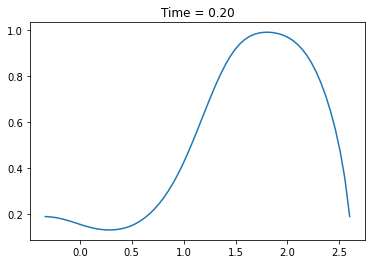

In [42]:
value = 0.2

t_idx = np.abs(time - value).argmin()
plt.plot(xx, rho[:, t_idx], label='After')
plt.title(f'Time = {time[t_idx]:.2f}')
plt.show()

In [35]:
x = spatial_domain(100, 0, 1)
#xx, uu, Pg, e, rho, moment = sod_test(nx, ny, nz, nt, x, P0, rho0)
u, rho, P = analytical_solution(x)

Region 1
100
100
100
Region 5
100
100
100
Region 2
100
100
100
Region 4
100
100
100
Region 3
100
100
100
[3.43547907 3.4109058  3.38745457 3.3650865  3.34376363 3.3234489
 3.30410612 3.2857     3.26819609 3.25156082 3.23576145 3.22076607
 3.2065436  3.19306376 3.18029709 3.16821491 3.15678932 3.14599318
 3.13580012 3.12618452 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.1        0.1        0.1        0.1
 0.1        0.1        0.1        0.1        

/tmp/ipykernel_2577/371714592.py:357: RuntimeWarning: invalid value encountered in power
  return rho1*(arg)**(power)


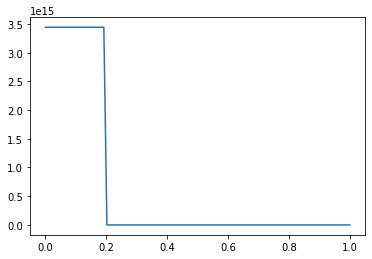

In [39]:
plt.plot(x, u)

Analytical Sod tube. Needs to split the region into 5. Ask Camilla or Aline about it???